In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
import json
pd.set_option('display.max_rows', 1000)
%matplotlib inline

In [41]:
# Read config
with open('config.json') as json_file:
    f = json.load(json_file)
    NUMBER_OF_QUERIES = f['number_of_queries']
    REPETITIONS = f['repetitions']
    ROWS = f['rows']
    SELECTIVITIES = [f['selectivity']]
    COLS = f['cols']
    EXPS_DEFAULTS = f['experiments']
    PARTITION_SIZE = f['partition_size']
    PROGRESSIVE_INDEX_DELTAS = f['deltas']

# Algorithms and Experiments defitions
algorithms = {
    'AverageKDTree': {
        'name': 'average_kd_tree',
        'color': 'red',
        'dash': 'dot',
        'show_name': 'AvgKD',
        'type': 'full_index',
        'delta': '0.0',
        'partition_size': PARTITION_SIZE
    },
    'MedianKDTree': {
        'name': 'median_kd_tree',
        'color': 'red',
        'dash': 'solid',
        'show_name': 'MedKD',
        'type': 'full_index',
        'delta': '0.0',
        'partition_size': PARTITION_SIZE
    },
    'CrackingKDTree': {
        'name': 'cracking_kd_tree',
        'color': 'green',
        'dash': 'dot',
        'show_name': 'AKD',
        'type': 'adaptive',
        'delta': '0.0',
        'partition_size': PARTITION_SIZE
    },
    'Quasii': {
        'name': 'quasii',
        'color': 'green',
        'dash': 'solid',
        'show_name': 'Q',
        'type': 'adaptive',
        'delta': '0.0',
        'partition_size': PARTITION_SIZE
    },
    'FullScan': {
        'name': 'full_scan_cl',
        'color': 'black',
        'dash': 'dot',
        'show_name': 'FS',
        'type': 'full_index',
        'partition_size': '0',
        'delta':'0.0',
    }
}

for key, value in algorithms.items():
    name = value['name']
    delta = value['delta']
    partition_size = value['partition_size']
    algorithms[key]['alg_id'] = f"{name}-{delta}-{partition_size}"
    
deltas = PROGRESSIVE_INDEX_DELTAS

for i in deltas:
    # For the delta experiment
    temp = {
        f'ProgressiveIndex_{i}': {
            'name': 'progressive_index',
            'color': '',
            'dash': 'solid',
            'marker': 'x-open',
            'show_name': f'PKD({i})',
            'type': 'adaptive',
            'delta': f'{i}',
            'partition_size': '1024'
        }
    }
    algorithms = {**algorithms, **temp}

for key, value in algorithms.items():
    name = value['name']
    delta = value['delta']
    partition_size = value['partition_size']
    algorithms[key]['alg_id'] = f"{name}-{delta}-{partition_size}"

    
# Synthetic Experiments
experiments = {}

for i in COLS:
    temp = {
        f'Uniform{i}': {
            "name": f"Unif({i})",
            'name-in-file': 'uniform',
            'n_rows': ROWS,
            'n_queries': NUMBER_OF_QUERIES,
            'n_cols': f'{i}',
            'sel': '0.01',
        }
    }
    experiments = {**experiments, **temp}
    
for key, value in experiments.items():
    name = value['name-in-file']
    rows = value['n_rows']
    n_queries = value['n_queries']
    cols = value['n_cols']
    sel = value['sel']
    experiments[key]['exp_id'] = f"{name}-{rows}-{n_queries}-{cols}-{sel}"

In [42]:
# Input/Output
def read(alg, exp):
    if exp.startswith('Shifting'):
        n_queries_per_run = 10
        uni = read(alg, 'Uniform' + experiments[exp]['n_cols'])
        n_runs = int(len(uni)/n_queries_per_run) - 1
        df_final = uni.head(n_queries_per_run)
        for _ in range(int(n_runs)):
            temp = uni.head(n_queries_per_run).copy()
            df_final = df_final.append(temp, ignore_index=True)
    else:
        df = pd.read_csv(f"results/{algorithms[alg]['alg_id']}-{experiments[exp]['exp_id']}.csv")
        repetitions = df['repetition'].max() + 1
        step = int(len(df.index)/repetitions)
        df_final = df[:step].copy().reset_index()
        for rep in range(1, repetitions):
            df_final += df[step * (rep) : step * (rep + 1)].copy().reset_index()

        df_final = df_final/repetitions
    
    if 'index_search_time' not in df_final:
        df_final['index_search_time'] = 0.0
    if 'tuples_scanned' not in df_final:
        df_final['tuples_scanned'] = 0.0
    if 'number_of_nodes' not in df_final:
        df_final['number_of_nodes'] = 0.0
    df_final['query_time'] = df_final['initialization_time'] + df_final['index_search_time'] + df_final['scan_time'] + df_final['adaptation_time']
    df_final['query_time_cumsum'] = df_final['query_time'].cumsum()
    return df_final

                     
def read_multiple(algs, exp):
    ''' Reads multiple algorithms in an experiment, return three arrays: dfs, colors, names
    '''
    dfs = []
    colors = []
    names = []
    dashes = []
    for alg in algs:
        dfs.append(read(alg, exp))
        names.append(algorithms[alg]['show_name'])
        colors.append(algorithms[alg]['color'])
        dashes.append(algorithms[alg]['dash'])
    
    return dfs, colors, dashes, names,

                     
def save_figure(fig, fig_name):
    fig.write_image(f"figures/{fig_name}", width=1024, height=768)
                     
def save_table(table, table_name):
    with open(f"tables/{table_name}", 'w') as f:
        f.write(table)

In [43]:
# Helper methods
def get_first_query(df):
    return df['query_time'].iloc[0]

def get_payoff(df, baseline):
    p = [i for i, x in enumerate(df['query_time_cumsum'] - (baseline['query_time_cumsum'])) if x > 0]
    if len(p) == 0:
        return len(df)
    return p[-1]

def get_convergence(df, df_type=''):
    if df_type == 'full_index':
        return 0
    c = [i for i, x in enumerate(df['adaptation_time']) if x != 0.0]
    if(len(c) == 0):
        return len(c)
    else:
        return c[-1]

def get_robustness(df, df_type=''):
    if df_type == 'full_index':
        return 0
    return np.var(df['query_time'][:min(50, get_convergence(df, df_type))])

def get_total_time(df, lower=0, upper=-1):
    return df['query_time'][lower:upper].sum()

# First Query

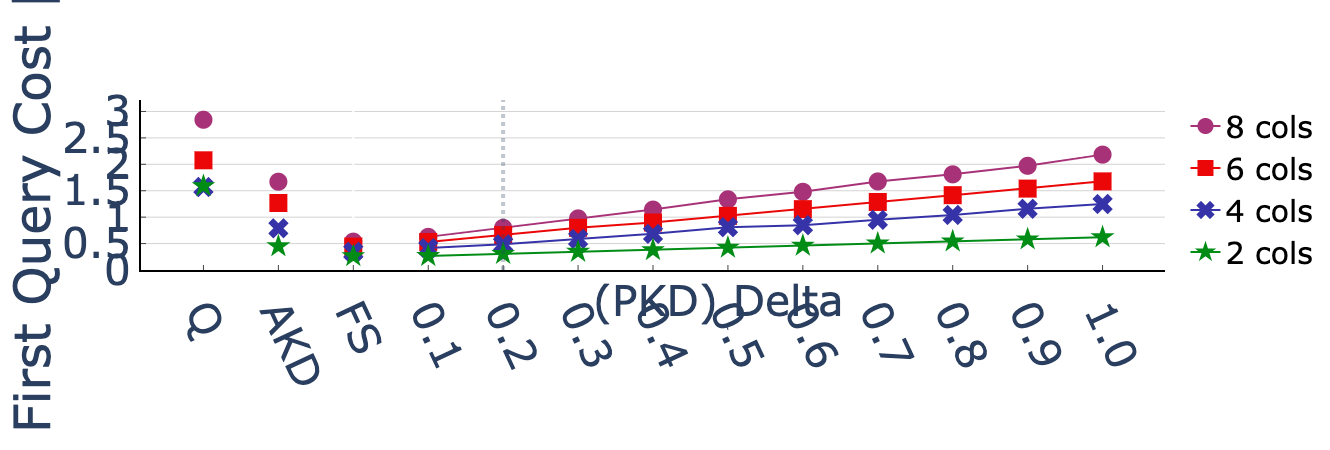

In [48]:
fig = create_figure()

cols = [8, 6, 4, 2]
markers = delta_markers
colors = ['rgba(168, 50, 119, 1)', 'rgba(235, 7, 7, 1)', 'rgba(54, 50, 168, 1)', 'rgba(1, 140, 22, 1)']
markers = delta_markers

lines = []
shapes = []

for i, marker, color in zip(cols, markers, colors):

    fq_times = []
    for d in deltas:
        fq_times.append(get_first_query(read(f'ProgressiveIndex_{d}', f'Uniform{i}')))
    lines.append(
        go.Scatter(
            name=f'{i} cols',
            x=deltas,
            y=fq_times,
            mode='lines+markers',
            marker=dict(
                size=18,
                symbol=marker
            ),
            marker_color=color
        )
    )
    
    # add other indices values
    
    lines.append(
        go.Scatter(
            name=f'{i}FullScan',
            x=[-0.0],
            y=[get_first_query(read(f'FullScan', f'Uniform{i}'))],
            mode='markers',
            marker_color=color,
            marker=dict(
                size=18,
                symbol=marker
            ),
            showlegend=False
        )
    )
    
    lines.append(
        go.Scatter(
            name=f'{i}AKD',
            x=[-0.1],
            y=[get_first_query(read(f'CrackingKDTree' ,f'Uniform{i}'))],
            mode='markers',
            marker_color=color,
            marker=dict(
                size=18,
                symbol=marker
            ),
            showlegend=False
        )
    )
    
    lines.append(
        go.Scatter(
            name=f'{i}Quasii',
            x=[-0.2],
            y=[get_first_query(read(f'Quasii' ,f'Uniform{i}'))],
            mode='markers',
            marker_color=color,
            marker=dict(
                size=18,
                symbol=marker
            ),
            showlegend=False
        )
    )

# add line at 0.2 delta
shapes.append(
    dict(
        type= 'line',
        yref="paper", y0= 0, y1=1,
        x0= 0.2, x1=0.2,
        opacity=0.3,
        line=dict(
            width=4,
            dash="dot",
        )
    )
)

fig.add_traces(data=lines)
fig.update_layout(showlegend=True, yaxis_title='First Query Cost [s]', shapes=shapes)
fig.update_xaxes(tickangle=65)
fig.update_layout(
#     xaxis=dict(
#         tickmode = 'linear',
#         tick0 = 0.0,
#         dtick = 0.1
#     )
    xaxis = dict(
        tickmode = 'array',
        tickvals = [-0.2, -0.1, -0.0] + deltas,
        ticktext = ['Q', 'AKD', 'FS'] + deltas
    ),
    yaxis= dict(
        tickmode ='linear',
        dtick=0.5
#         tickvals = [0, 0.5, 1, 1.5, 2, 2.5, 3],
#         ticktext = [0, 0.5, 1, 1.5, 2, 2.5, 3]
    ),
    annotations=[
        dict(
            x=0.5,
            y=-0.35,
            text="(PKD) Delta",
            xref="x",
            yref="paper",
        )
    ],
    autosize=True,
    margin=dict(
        b=180
    ),
)
fig.update_yaxes(rangemode="tozero")
fig

# Payoff

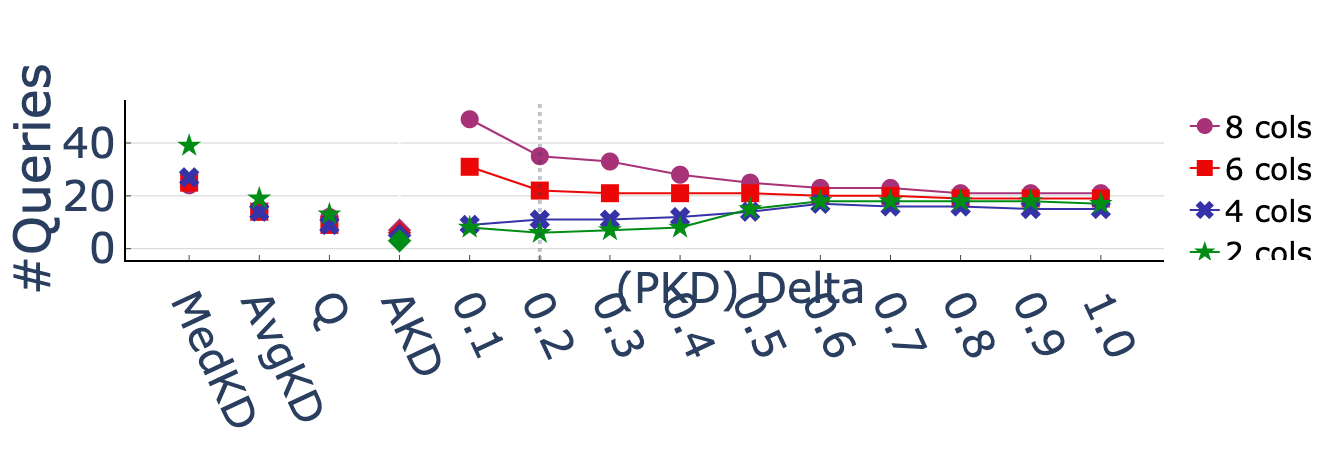

In [49]:
fig = create_figure()

cols = [8, 6, 4, 2]
markers = delta_markers
colors = ['rgba(168, 50, 119, 1)', 'rgba(235, 7, 7, 1)', 'rgba(54, 50, 168, 1)', 'rgba(1, 140, 22, 1)']

lines = []

for i, marker, color in zip(cols, markers, colors):
    fq_times = []
    for d in deltas:
        fq_times.append(get_payoff(read(f'ProgressiveIndex_{d}', f'Uniform{i}'), read('FullScan', f'Uniform{i}')))
    lines.append(
        go.Scatter(
            name=f'{i} cols',
            x=deltas,
            y=fq_times,
            mode='lines+markers',
            marker=dict(
                size=18,
                symbol=marker
            ),
            marker_color=color
        )
    )
    
    # add other indices values
    lines.append(
        go.Scatter(
            name=f'{i}AKD',
            x=[-0.0],
            y=[get_payoff(read(f'CrackingKDTree' ,f'Uniform{i}'), read('FullScan', f'Uniform{i}'))],
            mode='markers',
            marker_color=color,
            marker=dict(
                size=18,
                symbol='diamond'
            ),
            showlegend=False
        )
    )
    
    lines.append(
        go.Scatter(
            name=f'{i}Quasii',
            x=[-0.1],
            y=[get_payoff(read(f'Quasii' ,f'Uniform{i}'), read('FullScan', f'Uniform{i}'))],
            mode='markers',
            marker_color=color,
            marker=dict(
                size=18,
                symbol=marker
            ),
            showlegend=False
        )
    )
    
    lines.append(
        go.Scatter(
            name=f'{i}AvgKD',
            x=[-0.2],
            y=[get_payoff(read(f'AverageKDTree' ,f'Uniform{i}'), read('FullScan', f'Uniform{i}'))],
            mode='markers',
            marker_color=color,
            marker=dict(
                size=18,
                symbol=marker
            ),
            showlegend=False
        )
    )
    
    lines.append(
        go.Scatter(
            name=f'{i}MedKD',
            x=[-0.3],
            y=[get_payoff(read(f'MedianKDTree' ,f'Uniform{i}'), read('FullScan', f'Uniform{i}'))],
            mode='markers',
            marker_color=color,
            marker=dict(
                size=18,
                symbol=marker
            ),
            showlegend=False
        )
    )

# adding the 6 columns with 50% per attribute
# fq_times = []
# for d in deltas:
#     fq_times.append(get_payoff(read(f'ProgressiveIndex_{d}', f'Uniform6_50'), read('FullScan', f'Uniform6_50')))
# lines.append(
#     go.Scatter(
#         name=f'6 cols (50%)',
#         x=deltas,
#         y=fq_times,
#         mode='lines+markers'
#     )
# )

fig.add_traces(data=lines)
fig.update_layout(showlegend=True, yaxis_title='#Queries')
fig.update_xaxes(tickangle=65)
fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = [-0.3, -0.2, -0.1, -0.0] + deltas,
        ticktext = ['MedKD', 'AvgKD', 'Q', 'AKD'] + deltas
    ),
    shapes=[
        dict(
            type= 'line',
            yref="paper", y0= 0, y1=1,
            x0= 0.2, x1=0.2,
            opacity=0.3,
            line=dict(
                width=4,
                dash="dot",
            )
        )
    ],
    annotations=[
        dict(
            x=0.5,
            y=-0.35,
            text="(PKD) Delta",
            xref="x",
            yref="paper",
        )
    ],
    autosize=True,
    margin=dict(
        b=190
    ),
)
fig

# Convergence

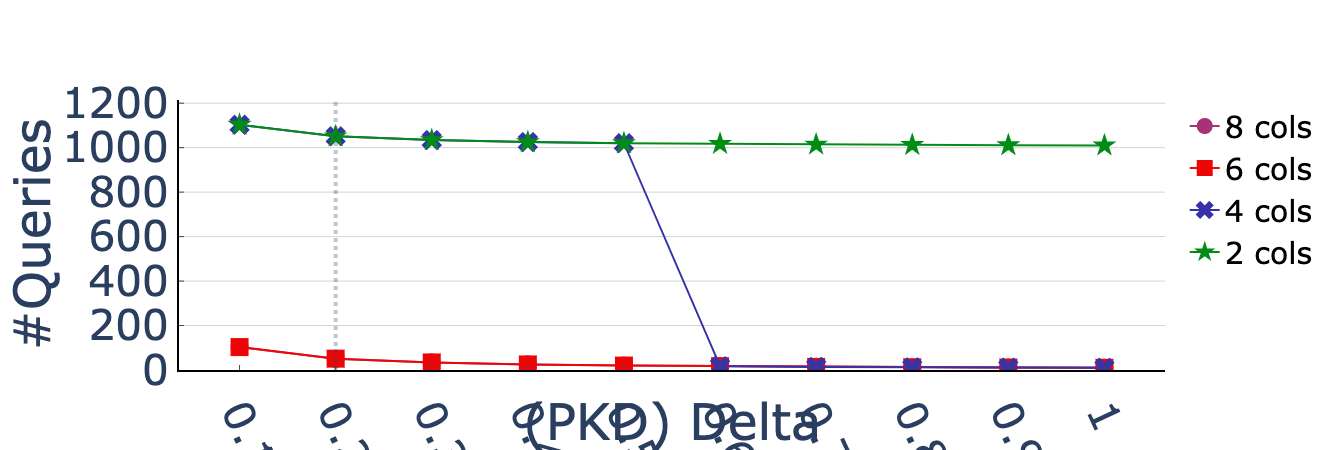

In [50]:
fig = create_figure()

cols = [8, 6, 4, 2]
markers = delta_markers
colors = ['rgba(168, 50, 119, 1)', 'rgba(235, 7, 7, 1)', 'rgba(54, 50, 168, 1)', 'rgba(1, 140, 22, 1)']

lines = []

for i, marker, color in zip(cols, markers, colors):
    fq_times = []
    for d in deltas:
        fq_times.append(get_convergence(read(f'ProgressiveIndex_{d}', f'Uniform{i}')))
    lines.append(
        go.Scatter(
            name=f'{i} cols',
            x=deltas,
            y=fq_times,
            mode='lines+markers',
            marker=dict(
                size=18,
                symbol=marker
            ),
            marker_color=color
        )
    )

fig.add_traces(data=lines)
fig.update_layout(showlegend=True, yaxis_title='#Queries', xaxis_title='<br>(PKD) Delta')
fig.update_xaxes(tickangle=65)
fig.update_layout(
    xaxis=dict(
        tickmode = 'linear',
        tick0 = 0.0,
        dtick = 0.1
    ),
    shapes=[
        dict(
            type= 'line',
            yref="paper", y0= 0, y1=1,
            x0= 0.2, x1=0.2,
            opacity=0.3,
            line=dict(
                width=4,
                dash="dot",
            )
        )
    ]
)
fig.update_yaxes(rangemode="tozero")
fig

# Cumulative cost after convergence vs total cumulative cost

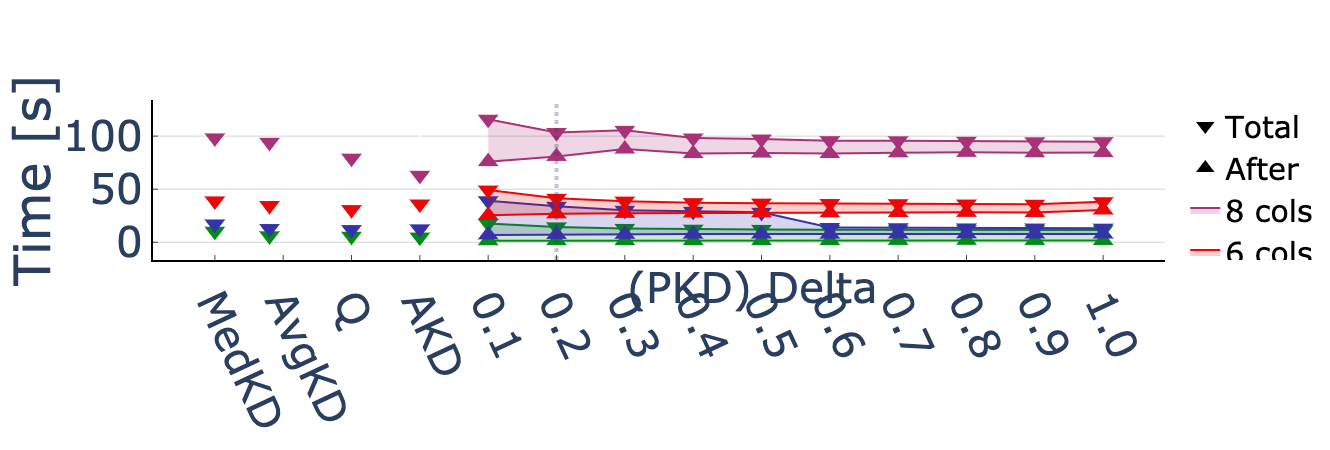

In [47]:
algs = [f'ProgressiveIndex_{d}' for d in deltas]
exp = 'Uniform8'
fig = create_figure()

cols = [2, 4, 6, 8]
markers = delta_markers
colors = ['rgba(168, 50, 119, 1)', 'rgba(235, 7, 7, 1)', 'rgba(54, 50, 168, 1)', 'rgba(1, 140, 22, 1)']
colors.reverse()
fill_colors = ['rgba(168, 50, 119, 0.2)', 'rgba(235, 7, 7, 0.2)', 'rgba(54, 50, 168, 0.2)', 'rgba(1, 140, 22, 0.2)']
fill_colors.reverse()
lines = []

for i, marker, color, fill_color in zip(cols, markers, colors, fill_colors):
    fq_times = []
    # Plot afters
    for d in deltas:
        fq_times.append(
            get_total_time(
                read(f'ProgressiveIndex_{d}', f'Uniform{i}'),
                lower=get_convergence(read(f'ProgressiveIndex_{d}', f'Uniform{i}'))
            )
        )
    lines.append(
        go.Scatter(
            name=f'{i} cols',
            x=deltas,
            y=fq_times,
            mode='lines',
            marker_color=color,
            showlegend=False
        )
    )

    
    # Plot totals
    fq_times = []
    for d in deltas:
        fq_times.append(
            get_total_time(
                read(f'ProgressiveIndex_{d}', f'Uniform{i}')
            )
        )
    lines.append(
        go.Scatter(
            name=f'{i} cols',
            x=deltas,
            y=fq_times,
            mode='lines',
            marker_color=color,
            fill='tonexty',
            fillcolor=fill_color
        )
    )
    
    fq_times = []
    # Plot afters triangles
    for d in deltas:
        fq_times.append(
            get_total_time(
                read(f'ProgressiveIndex_{d}', f'Uniform{i}'),
                lower=get_convergence(read(f'ProgressiveIndex_{d}', f'Uniform{i}'))
            )
        )
    lines.append(
        go.Scatter(
            name=f'{i} cols',
            x=deltas,
            y=fq_times,
            mode='markers',
            marker_color=color,
            marker=dict(
                size=18,
                symbol='triangle-up'
            ),
            showlegend=False
        )
    )

    
    # Plot totals triangles
    fq_times = []
    for d in deltas:
        fq_times.append(
            get_total_time(
                read(f'ProgressiveIndex_{d}', f'Uniform{i}')
            )
        )
    lines.append(
        go.Scatter(
            name=f'{i} cols',
            x=deltas,
            y=fq_times,
            mode='markers',
            marker_color=color,
            marker=dict(
                size=18,
                symbol='triangle-down'
            ),
            showlegend=False
        )
    )
    
    # add other indices values
    lines.append(
        go.Scatter(
            name=f'{i}AKD',
            x=[-0.0],
            y=[get_total_time(read(f'CrackingKDTree' ,f'Uniform{i}'))],
            mode='markers',
            marker_color=color,
            marker=dict(
                size=18,
                symbol='triangle-down'
            ),
            showlegend=False
        )
    )
    
    lines.append(
        go.Scatter(
            name=f'{i}Quasii',
            x=[-0.1],
            y=[get_total_time(read(f'Quasii' ,f'Uniform{i}'))],
            mode='markers',
            marker_color=color,
            marker=dict(
                size=18,
                symbol='triangle-down'
            ),
            showlegend=False
        )
    )
    
    lines.append(
        go.Scatter(
            name=f'{i}AvgKD',
            x=[-0.22],
            y=[get_total_time(read(f'AverageKDTree' ,f'Uniform{i}'))],
            mode='markers',
            marker_color=color,
            marker=dict(
                size=18,
                symbol='triangle-down'
            ),
            showlegend=False
        )
    )
    
    lines.append(
        go.Scatter(
            name=f'{i}MedKD',
            x=[-0.3],
            y=[get_total_time(read(f'MedianKDTree' ,f'Uniform{i}'))],
            mode='markers',
            marker_color=color,
            marker=dict(
                size=18,
                symbol='triangle-down'
            ),
            showlegend=False
        )
    )


# Add triangles in the legend
lines.append(
        go.Scatter(
            name=f'After',
            x=[None],
            y=[None],
            mode='markers',
            marker_color='black',
            marker=dict(
                size=18,
                symbol='triangle-up'
            ),
        )
    )

lines.append(
        go.Scatter(
            name=f'Total',
            x=[None],
            y=[None],
            mode='markers',
            marker_color='black',
            marker=dict(
                size=18,
                symbol='triangle-down'
            ),
        )
    )



fig.add_traces(data=lines)
fig.update_layout(showlegend=True, yaxis_title='Time [s]',)
fig.update_xaxes(tickangle=65)
fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = [-0.3, -0.2, -0.1, -0.0] + deltas,
        ticktext = ['MedKD', 'AvgKD', 'Q', 'AKD'] + deltas
    ),
    shapes=[
        dict(
            type= 'line',
            yref="paper", y0= 0, y1=1,
            x0= 0.2, x1=0.2,
            opacity=0.3,
            line=dict(
                width=4,
                dash="dot",
            )
        )
    ],
    annotations=[
        dict(
            x=0.5,
            y=-0.35,
            text="(PKD) Delta",
            xref="x",
            yref="paper",
        )
    ],
    autosize=True,
    margin=dict(
        b=150
    ),
)
fig

In [58]:
len(read('ProgressiveIndex_0.1', 'Uniform8'))

1000